<a href="https://colab.research.google.com/github/DVerma11/Reddit_Anxiety_Symptoms_Narratives_NLP_Exploration/blob/main/Section_5_NER_with_medCAT_Symptoms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 5: MedCAT(Medical Concept Annotation Tool)

Pre-trained on clinical notes and linked to concepts in SNOMED CT, UMLS**

## 5.1 Install medcat**

In [1]:
# Install medcat
! pip install medcat~=1.16.0
# install seaborn
! pip install seaborn
try:
    from medcat.cat import CAT
except:
    print("WARNING: Runtime will restart automatically and please run other cells thereafter.")
    exit()

/usr/local/lib/python3.12/dist-packages/medcat/cat.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Restart the runtime if on colab, sometimes necessary after installing models

# 5.2 Import Packages

In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from matplotlib import pyplot as plt
from medcat.cat import CAT

# 5.3 Load the MedCAT modelpack and create CAT

In [3]:
import os

DATA_DIR = "./data_p3.2/"
os.makedirs(DATA_DIR, exist_ok=True)

model_pack_path = os.path.join(DATA_DIR, "medmen_wstatus_2021_oct.zip")

if not os.path.exists(model_pack_path):
    !wget https://cogstack-medcat-example-models.s3.eu-west-2.amazonaws.com/medcat-example-models/medmen_wstatus_2021_oct.zip -P $DATA_DIR


--2026-01-13 03:23:01--  https://cogstack-medcat-example-models.s3.eu-west-2.amazonaws.com/medcat-example-models/medmen_wstatus_2021_oct.zip
Resolving cogstack-medcat-example-models.s3.eu-west-2.amazonaws.com (cogstack-medcat-example-models.s3.eu-west-2.amazonaws.com)... 52.95.142.114, 16.12.17.6, 3.5.246.25, ...
Connecting to cogstack-medcat-example-models.s3.eu-west-2.amazonaws.com (cogstack-medcat-example-models.s3.eu-west-2.amazonaws.com)|52.95.142.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561947681 (536M) [application/zip]
Saving to: ‘./data_p3.2/medmen_wstatus_2021_oct.zip’

medmen_wstatus_2021 100%[===================>] 535.92M  22.5MB/s    in 25s     

2026-01-13 03:23:26 (21.6 MB/s) - ‘./data_p3.2/medmen_wstatus_2021_oct.zip’ saved [561947681/561947681]



In [4]:
# Create CAT - the main class from medcat used for concept annotation
cat = CAT.load_model_pack(model_pack_path)

/usr/local/lib/python3.12/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_md' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
INFO:medcat.cat:{
  "Model ID": null,
  "Last Modified On": null,
  "History (from least to most recent)": [],
  "Description": "No description",
  "Source Ontology": null,
  "Location": null,
  "MetaCAT models": {},
  "Basic CDB Stats": {},
  "Performance": {
    "ner": {},
    "meta": {}
  },
  "Important Parameters (Partial view, all available in cat.config)": {
    "config.ner.min_name_len": {
      "value": 3,
      "description": "Minimum detection length (found terms/mentions shorter than this will not be detected)."
    },
    "config.ner.upper_ca

# 5.4 Load the dataset

In [5]:
import pandas as pd

# Load the Step3 file
symptom_phrases_negation_df = pd.read_csv("Step3_symptom_phrases_negation.csv", encoding="utf-8")

# Filter only non-negated phrases
non_negated_df = symptom_phrases_negation_df[symptom_phrases_negation_df["is_negated"] == False].copy()

# Optional: reset index
non_negated_df.reset_index(drop=True, inplace=True)


# Preview
non_negated_df.head()


,post_id,comment_id,parent_id,comment_body,author_hash,score,created_utc,title,post_body,full_text,full_text_clean,comment_body_clean,post_body_clean,comment_body_clean_phrases,symptom_phrases_str,phrase_index,is_negated,negation_cue
0,1czzuoo,l5k13qf,t3_1czzuoo,omg you have no idea how much better i feel. i...,bfc763f738dd81303e35d089fde639e68495eab77cc322...,110,1.716601e+09,Here is a full list of anxiety symptoms I deal...,Anxiety easily can cause a million different s...,Here is a full list of anxiety symptoms I deal...,Here is a full list of anxiety symptoms I deal...,omg you have no idea how much better i feel. i...,anxiety easily can cause a million different s...,idea well feel,idea well feel; feeling; feel go die; go thera...,0.0,False,NaN
1,1czzuoo,l5k13qf,t3_1czzuoo,omg you have no idea how much better i feel. i...,bfc763f738dd81303e35d089fde639e68495eab77cc322...,110,1.716601e+09,Here is a full list of anxiety symptoms I deal...,Anxiety easily can cause a million different s...,Here is a full list of anxiety symptoms I deal...,Here is a full list of anxiety symptoms I deal...,omg you have no idea how much better i feel. i...,anxiety easily can cause a million different s...,feeling,idea well feel; feeling; feel go die; go thera...,0.0,False,NaN
2,1czzuoo,l5k13qf,t3_1czzuoo,omg you have no idea how much better i feel. i...,bfc763f738dd81303e35d089fde639e68495eab77cc322...,110,1.716601e+09,Here is a full list of anxiety symptoms I deal...,Anxiety easily can cause a million different s...,Here is a full list of anxiety symptoms I deal...,Here is a full list of anxiety symptoms I deal...,omg you have no idea how much better i feel. i...,anxiety easily can cause a million different s...,feel go die,idea well feel; feeling; feel go die; go thera...,0.0,False,NaN
3,1czzuoo,l5k13qf,t3_1czzuoo,omg you have no idea how much better i feel. i...,bfc763f738dd81303e35d089fde639e68495eab77cc322...,110,1.716601e+09,Here is a full list of anxiety symptoms I deal...,Anxiety easily can cause a million different s...,Here is a full list of anxiety symptoms I deal...,Here is a full list of anxiety symptoms I deal...,omg you have no idea how much better i feel. i...,anxiety easily can cause a million different s...,go therapy,idea well feel; feeling; feel go die; go thera...,0.0,False,NaN
4,1czzuoo,l5k13qf,t3_1czzuoo,omg you have no idea how much better i feel. i...,bfc763f738dd81303e35d089fde639e68495eab77cc322...,110,1.716601e+09,Here is a full list of anxiety symptoms I deal...,Anxiety easily can cause a million different s...,Here is a full list of anxiety symptoms I deal...,Here is a full list of anxiety symptoms I deal...,omg you have no idea how much better i feel. i...,anxiety easily can cause a million different s...,take medication month,idea well feel; feeling; feel go die; go thera...,0.0,False,NaN


# 5.5 Apply model

Extract Sign or symptom
*   T047	Disease or Syndrome
*   T184	Sign or Symptom
*   T048	Mental or Behavioral Dysfunction


During the manual review of results, we identified some posts with words such as "Symptoms", "Illness (finding)", "Finding", "Clinical finding", "Disease" extracted as generic entities so these terms were explicity excluded from teh criterai. We also excluded Anxiety related terms such as "Anxiety", "Anxiety Disorders", "Generalized Anxiety Disorder", "Separation Anxiety Disorder","Anxiety state", since the research is to find symptoms and diseases associated with anxiety excluding anxieties.

 GENERIC_SYMPTOMS = {
    "Symptoms", "Illness (finding)", "Finding", "Clinical finding",
    "Anxiety symptoms", "Disease", "Anxiety", "Anxiety Disorders",
    "Generalized Anxiety Disorder", "Separation Anxiety Disorder","Anxiety state"
}

A gold standard dataset of symptoms, comorbidities, and coping skills was developed using literature which was used to validate the NLP application.


Explore dependency parsing and double-check that only unique entities were extracted from each user.

Also explore bag or words approach and approximate string-matching algorithm (ASM) for name entity recognition NER.


For the validation dataset, the application outcomes for each class were compared against the industry gold standards to determine the application’s performance using statistical measures such as precision, recall,accuracy, and F1 score.

In [7]:
# 1. Apply the model with categories - T184, T048, T047
# Create a text column for NLP
non_negated_df['text_for_nlp'] = non_negated_df['comment_body_clean_phrases'].fillna("")


# -------------------------------
# Filter CDB to relevant types
# -------------------------------
type_ids_filter = ['T184','T048', 'T047']  # symptom, mental dysfunction, disease
cui_filters = set()
for type_id in type_ids_filter:
    cui_filters.update(cat.cdb.addl_info['type_id2cuis'][type_id])

cat.cdb.config.linking['filters']['cuis'] = cui_filters
print(f"Filtered CDB size: {len(cui_filters)} CUIs")

Filtered CDB size: 2017 CUIs


In [8]:
# -------------------------------
# 2. Prepare data for multiprocessing
# -------------------------------
text_col = 'text_for_nlp'  # use the column prepared for NLP

in_data = []
for doc_id, row in non_negated_df.iterrows():
    text = row[text_col]
    if pd.notna(text):
        in_data.append((doc_id, str(text)))

batch_size_chars = 500_000  # adjust based on memory/size
nproc = 8  # adjust to available CPU cores

# -------------------------------
# Run MedCAT multiprocessing
# -------------------------------
results = cat.multiprocessing_batch_char_size(
    in_data,
    batch_size_chars=batch_size_chars,
    nproc=nproc
)

Processing:   0%|          | 0/4061 [00:00<?, ?batch/s]

INFO:medcat.cat:Annotated until now: 0 docs; Current BS: 4061 docs; Elapsed time: 0.00 minutes


In [9]:
# -------------------------------
# 3.Process MedCAT results
# -------------------------------
TARGET_TYPES = {'T184', 'T048', 'T047'}
processed_entities = []

for doc_id, doc_result in results.items():
    if not isinstance(doc_result, dict):
        continue

    entities = doc_result.get('entities', {})

    for ent in entities.values():
        processed_entities.append({
            'row_idx': doc_id,
            'cui': ent.get('cui'),
            'name': ent.get('pretty_name'),
            'type_ids': ent.get('type_ids', []),
            'is_negated': ent.get('is_negated', False),
            'confidence': ent.get('confidence', 0)
        })

# Convert to DataFrame
entities_df = pd.DataFrame(processed_entities)
print("Total entities:", len(entities_df))

Total entities: 1468


 # 5.6 Define Exclude terms

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Target categories
TARGET_TYPES = {
    'T184': 'Sign or Symptom',
    'T048': 'Mental or Behavioral Dysfunction',
    'T047': 'Disease or Syndrome'

}

# Generic entities to exclude
exclude_terms = {
    "anxiety", "anxious", "anxieties", "superanxious", "overanxious", "anxiousness",
    "ill", "bad anxiety", "Symptoms", "Illness (finding)", "Finding", "Clinical finding",
    "Anxiety symptoms", "Disease", "Anxiety", "Anxiety Disorders",
    "Generalized Anxiety Disorder", "Separation Anxiety Disorder","Anxiety state",
    "symptoms", "symptom", "anxiety symptom", "anxiety disorder", "anxiety symptom", "stress anxiety", "bad"}


# -------------------------------
# Create a row-wise dictionary for each category
# -------------------------------
category_entities = defaultdict(list)  # category -> list of entity names

for _, row in entities_df.iterrows():
    for t in row['type_ids']:
        if t in TARGET_TYPES:
            if row['name'] not in exclude_terms:  # exclude terms
                category_entities[t].append(row['name'])


# 5.7  List top categories without Normalization

In [13]:
# List top 20 per category
top_entities_per_category = {}

for t, cat_name in TARGET_TYPES.items():
    counts = pd.Series(category_entities[t]).value_counts().reset_index()
    counts.columns = ['entity', 'count']
    top_entities_per_category[t] = counts.head(100)
    print(f"\nTop  {cat_name} ({t}) entities:")
    display(top_entities_per_category[t])



Top  Sign or Symptom (T184) entities:


,entity,count
0,Pain,79
1,Nausea,65
2,Chest Pain,60
3,Chest tightness,53
4,Headache,50
5,Dizziness,49
6,Tired,16
7,Sleeplessness,15
8,Hot flushes,14
9,Diarrhea,14



Top  Mental or Behavioral Dysfunction (T048) entities:


,entity,count
0,Tension,26
1,Obsessive-Compulsive Disorder,22
2,Mental Suffering,16
3,Mental Depression,16
4,life stress,15
5,Hallucinations,11
6,forget,7
7,dissociation,7
8,Dementia,6
9,Attention deficit hyperactivity disorder,5



Top  Disease or Syndrome (T047) entities:


,entity,count
0,Hypertensive disease,7
1,disease rare,5
2,Peptic Esophagitis,4
3,Migraine Disorders,4
4,Heart Diseases,4
5,Epilepsy,3
6,Cerebrovascular accident,3
7,Obesity,2
8,Cardiac Arrest,2
9,Asthma,2


Since some categories in symptoms are similar, we will group them together by defining Normalization

# 5.8 Define Normalization

In [39]:
symptom_normalization_map = {
    'Abdominal Pain':'Abdominal pain/cramps',
    'Abdominal cramps': 'Abdominal pain/cramps',
    'Abdominal pain': 'Abdominal pain/cramps',
    'Chest Pain': 'Chest discomfort/pain/tightness',
    'Chest tightness': 'Chest discomfort/pain/tightness',
    'Chest discomfort':'Chest discomfort/pain/tightness',
    'Breathing abnormally deep': 'Breathing difficulty/Wheezing/coughing',
    'Pain':'Pain in body',
    'Chest pain':'Pain in body',
    'Shoulder Pain': 'Pain in body',
    'Pain in left arm': 'Pain in body',
    'Pain in right arm': 'Pain in body',
    'Pain in left leg': 'Pain in body',
    'Pain in right leg': 'Pain in body',
    'Neck Pain': 'Pain in body',
    'Groin pain': 'Pain in body',
    'Pain in back': 'Pain in body',
    'Pelvic Pain':'Pain in body',
    'Chronic pain':'Pain in body',
    'Arthralgia (hip)': 'Pain in body',
    'Mental Depression': 'Major Depressive Disorder/Depression',
    'Depression': 'Major Depressive Disorder/Depression',
    'depression postnatal': 'Major Depressive Disorder/Depression',
    'Major Depressive Disorder': 'Major Depressive Disorder/Depression',
    'dissociation':'Dissociative disorder/dissociation',
    'Dissociative disorder':'Dissociative disorder/dissociation',
    'Dementia': 'Dementia/Memory impairment',
    'Memory impairment': 'Dementia/Memory impairment',
    'Obsessive compulsive behavior': 'Obsessive compulsive behavior/obsession',
    'Obsession': 'Obsessive compulsive behavior/obsession',
    'Obsessive compulsive disorder': 'Obsessive compulsive behavior/obsession',
    'Tired': 'Fatigue',
    'Fatigue': 'Fatigue',
    'nausea': 'vomiting/nausea',
    'nauseated': 'vomiting/nausea',
    'vomiting': 'vomiting/nausea',
    'vomit': 'vomiting/nausea',
    'numb': 'numbness',
    'Weakness':'Weakness/muscle weakness',
    'muscle weakness': 'Weakness/muscle weakness',
    'burn chest': 'heart/chest burn',
    'chest burn': 'heart/chest burn',
    'heart burn': 'heart/chest burn',
    'Heartburn': 'heart/chest burn',
    '[D]Groin pain': 'Pain in body',
    'Moderate pain': 'Pain in body',
    'Breathing difficulty':'shortness of breath',
    'difficulty breathing': 'shortness of breath',
    'Loose stool': 'GI Symptoms',
    'gastrointestinal symptom':'GI Symptoms',
    'Coughing': 'Breathing difficulty/Wheezing/coughing',
    'wheezing': 'Breathing difficulty/Wheezing/coughing',
    'Breathing difficulty': 'Breathing difficulty/Wheezing/coughing',
    'Breathing difficulty': 'Breathing difficulty/Wheezing/coughing',
    'cough': 'Breathing difficulty/Wheezing/coughing',
    'forget': 'forgetfulness'

}

# Make a lowercase version of the normalization map
symptom_normalization_map_lower = {k.lower(): v for k, v in symptom_normalization_map.items()}



## 5.9 Apply normalization

In [40]:
#apply normalization
# First, define a function to normalize an entity
def normalize_entity_ci(entity, normalization_map):
    if not isinstance(entity, str) or not entity.strip():
        return entity

    # lowercase for case-insensitive matching
    entity_lower = entity.strip().lower()

    # return normalized value if in map
    return normalization_map.get(entity_lower, entity.strip())


# Apply normalization while counting top entities
top_entities_per_category = {}

for t, cat_name in TARGET_TYPES.items():
    # Normalize all entities in this category
    normalized_entities = [normalize_entity(ent, symptom_normalization_map)
                           for ent in category_entities[t]]

    # Count occurrences
    counts = pd.Series(normalized_entities).value_counts().reset_index()
    counts.columns = ['entity', 'count']

    # Take top n per category
    top_entities_per_category[t] = counts.head(20)

    print(f"\nTop {cat_name} ({t}) entities:")
    display(top_entities_per_category[t])



Top Sign or Symptom (T184) entities:


,entity,count
0,Chest discomfort/pain/tightness,114
1,Pain in body,100
2,vomiting/nausea,75
3,Headache,50
4,Dizziness,49
5,Fatigue,28
6,Sleeplessness,15
7,Hot flushes,14
8,Diarrhea,14
9,Nervousness,14



Top Mental or Behavioral Dysfunction (T048) entities:


,entity,count
0,Tension,26
1,Obsessive-Compulsive Disorder,22
2,Major Depressive Disorder/Depression,20
3,Mental Suffering,16
4,life stress,15
5,Hallucinations,11
6,Dissociative disorder/dissociation,10
7,Dementia/Memory impairment,9
8,forgetfulness,7
9,Drug usage,5



Top Disease or Syndrome (T047) entities:


,entity,count
0,Hypertensive disease,7
1,disease rare,5
2,Peptic Esophagitis,4
3,Migraine Disorders,4
4,Heart Diseases,4
5,Epilepsy,3
6,Cerebrovascular accident,3
7,Obesity,2
8,Cardiac Arrest,2
9,Asthma,2


/tmp/ipython-input-107060434.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


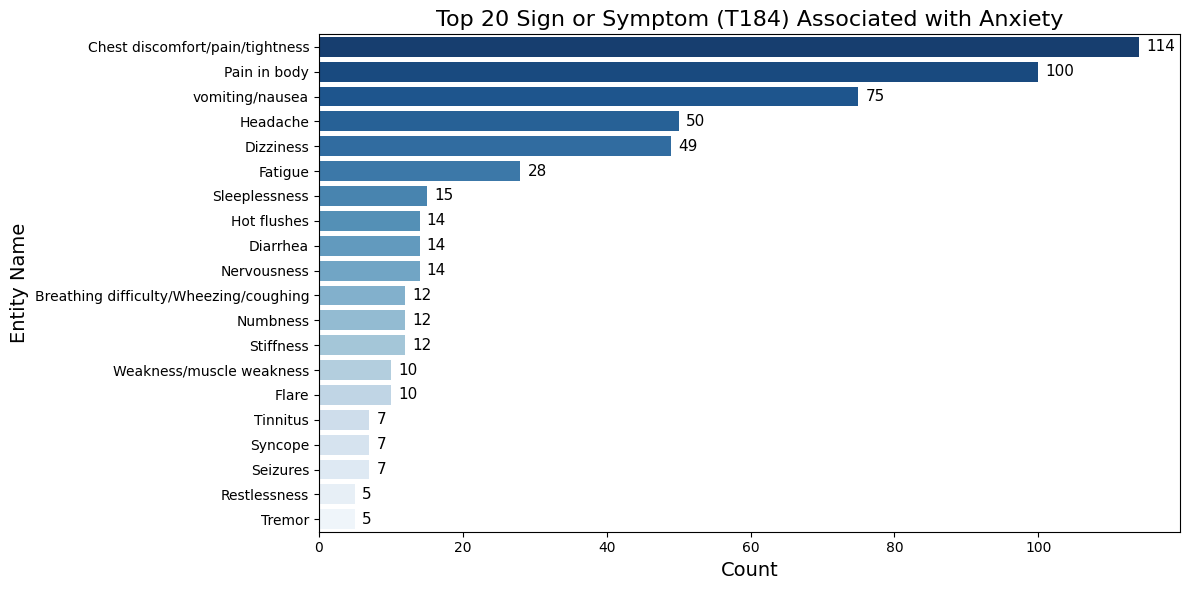

/tmp/ipython-input-107060434.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


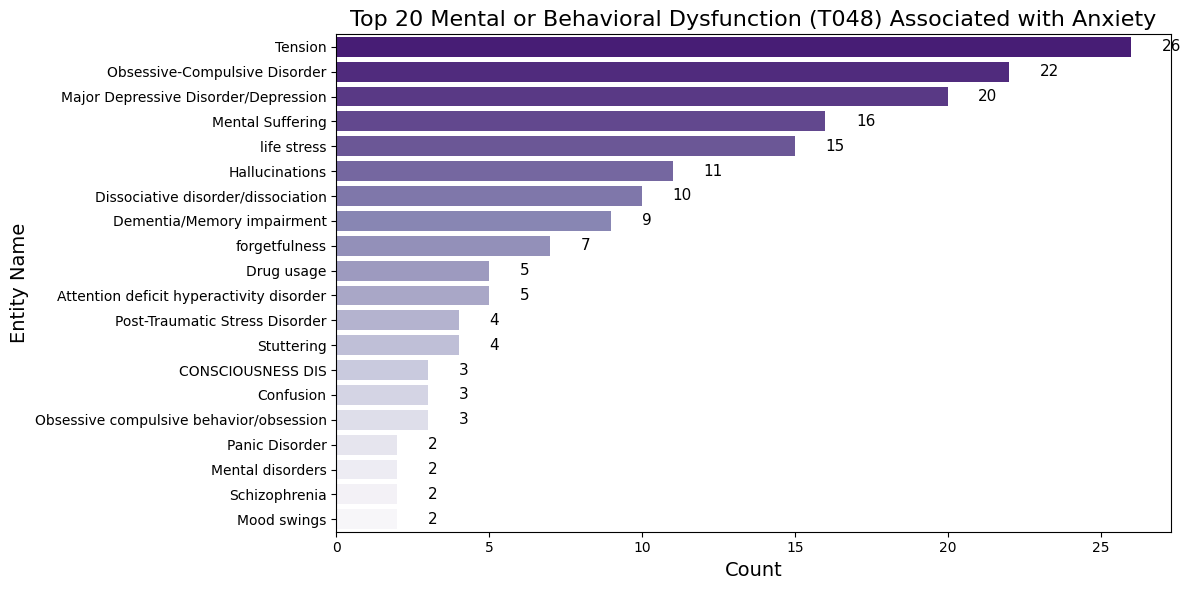

/tmp/ipython-input-107060434.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


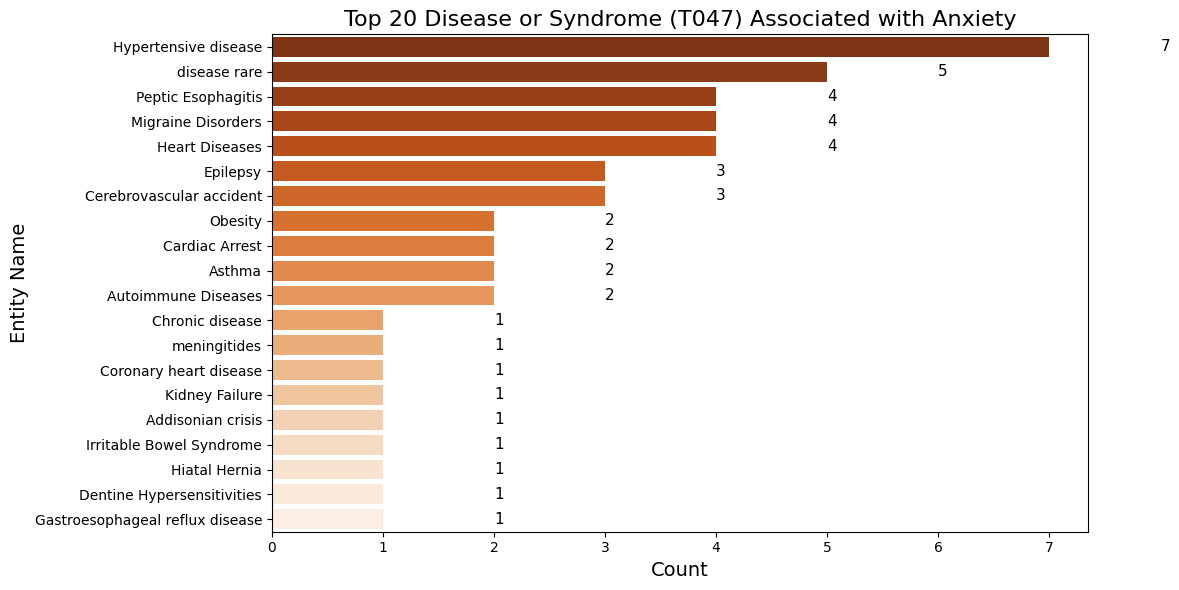

In [41]:
# Plotting top 20 per category
# Define a color palette for each category
CATEGORY_PALETTES = {
    'T184': 'Blues_r',   # Blue for Sign or Symptom
    'T048': 'Purples_r',  # Green for Mental or Behavioral Dysfunction
    'T047': 'Oranges_r'  # Orange for Disease or Syndrome
}
for t, cat_name in TARGET_TYPES.items():
    top_df = top_entities_per_category[t]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=top_df,
        y='entity',
        x='count',
        palette=CATEGORY_PALETTES[t]  # blue palette
    )

    plt.title(f"Top 20 {cat_name} ({t}) Associated with Anxiety", fontsize=16)
    plt.xlabel("Count", fontsize=14)
    plt.ylabel("Entity Name", fontsize=14)

    # Add count labels
    for i, v in enumerate(top_df['count']):
        plt.text(v + 1, i, str(v), va='center', fontsize=11)

    plt.tight_layout()
    plt.show()


End of Section